<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install transformers

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


In [5]:
import transformers
from datasets import load_dataset
import evaluate

Скачаем данные, посмотрим на их структуру и предварительно предобработаем

In [6]:
data_ru=pd.read_excel('data_problems.xlsx')

In [7]:
data_ru.head()

Unnamed: 0                                             Задача   Тема
0           0  Между девятью планетами Солнечной системы введ...  Графы
1           1  В стране Цифра есть 9 городов с названиями 1, ...  Графы
2           2  В государстве 100 городов, и из каждого из них...  Графы
3           3  В классе 30 человек. Может ли быть так, что 9 ...  Графы
4           4  В городе Маленьком 15 телефонов. Можно ли их с...  Графы

In [8]:
data_ru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5273 non-null   int64 
 1   Задача      5273 non-null   object
 2   Тема        5273 non-null   object
dtypes: int64(1), object(2)
memory usage: 123.7+ KB


In [9]:
data_ru['Тема'].value_counts()

Тема
Теория чисел     2396
Комбинаторика    1020
Дирихле           441
Многочлен         426
Графы             384
Геометрия         371
Инвариант         235
Name: count, dtype: int64

В данном датасете присутствует дисбалланс классов, таким образом по значению accuracy легче сделать неправильный вывод, следует также обратить внимание на micro/macro f1

In [10]:
data_ru=data_ru.drop(columns=['Unnamed: 0'])

In [11]:
data_ru.head()

Задача   Тема
0  Между девятью планетами Солнечной системы введ...  Графы
1  В стране Цифра есть 9 городов с названиями 1, ...  Графы
2  В государстве 100 городов, и из каждого из них...  Графы
3  В классе 30 человек. Может ли быть так, что 9 ...  Графы
4  В городе Маленьком 15 телефонов. Можно ли их с...  Графы

In [12]:
data_ru.columns=['text','labels'] # или label? Потом проверить и посмотреть примеры, но везде по-разному написано

In [13]:
#pip install pandas nltk

In [14]:
import nltk
from nltk.corpus import stopwords
import string


nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    if isinstance(text, str):

        text = text.lower()

        text = text.translate(str.maketrans('', '', string.punctuation))

        words = text.split()

        filtered_words = [word for word in words if word not in stop_words]

        return ' '.join(filtered_words)
data_ru['text'] = data_ru['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_ru['labels']=le.fit_transform(data_ru['labels'])

Классы модели

In [16]:
le.classes_

array(['Геометрия', 'Графы', 'Дирихле', 'Инвариант', 'Комбинаторика',
       'Многочлен', 'Теория чисел'], dtype=object)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X=data_ru['text']
y=data_ru['labels']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from datasets import Dataset, DatasetDict

Создадим Dataset для работы в библиотеке transformers

In [21]:
train_df, test_df = train_test_split(data_ru, test_size=0.2, stratify=data_ru['labels'])

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))


dataset_dict = DatasetDict({
       'train': train_dataset,
       'test': test_dataset
   })

In [22]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4218
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1055
    })
})

In [23]:
max(len(i.split()) for i in data_ru['text'])

353

In [24]:
np.mean([len(i.split()) for i in data_ru['text']])

31.654276502939503

In [25]:
np.median([len(i.split()) for i in data_ru['text']])

22.0

Посмотрим на длину предложений в датасете

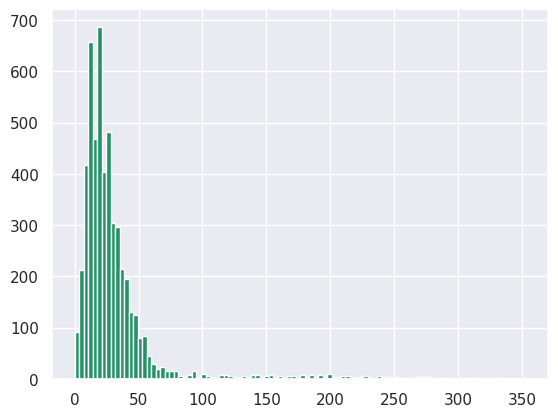

In [26]:
plt.hist([len(i.split()) for i in data_ru['text']],bins=100);

Большинство предложений не превышают 150 слов

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [52]:
def select_model(model,classes=len(le.classes_)):

    return transformers.BertForSequenceClassification.from_pretrained(model, num_labels=classes)

In [29]:
len(le.classes_)

7

Для получения токенизатора модели

In [31]:
from transformers import AutoTokenizer

In [53]:
def select_tokenizer(model):
    return AutoTokenizer.from_pretrained(model)



### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [33]:
model0=select_model('cointegrated/rubert-tiny2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Посмотрим на слои модели. Так как к базовой (backbone) модели при решении задачи классификации добавляется линейный классификационный слой, то при
заморозке backbone модели заморозим все слои, кроме классификационного. Для
этого посмотрим на названия слоев и архитектуру модели и в функции для заморозки в условии выберем нужные слои

In [34]:
for layer_name,_ in model0.named_parameters():
  print(layer_name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

Так как BertForSequenceClassification добавляет к исходной backbone модели (в данном случае эти модели из  задания не содержат классификационного слоя) линейный слой для классификации, для которого явно указали количество классов, то в функции заморозим веса слоев, за исключением последнего  

In [54]:
def freeze_backbone_function(model):

  for param,weights in model.named_parameters():
    if param not in ['classifier.weight','classifier.bias']:
        weights.requires_grad = False
    else:
        weights.requires_grad = True

  return model




### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

Напишем функции для вычисления метрики f1 и accuracy при решении задачи классификации

In [55]:

metric1 = evaluate.load('f1')
def compute_metrics1(eval_pred):
	logits, labels = eval_pred
	predictions = np.argmax(logits, axis=-1)
	return metric1.compute(predictions=predictions, references=labels, average="macro")

metric = evaluate.load('accuracy')
def compute_metrics(eval_pred):
	logits, labels = eval_pred
	predictions = np.argmax(logits, axis=-1)
	return metric.compute(predictions=predictions, references=labels)

Функция для тренировки с использованием Trainer

In [56]:
import copy
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
def train_transformer(transformer_model,train_dataset, test_dataset,num_epochs=5,lr = 1e-3,compute_metrics=compute_metrics,freeze_backbone=True): #может еще добавить параметры типа lr (хотя бы по умолчанию)


    transformer_model= copy.copy(transformer_model)##


    model=select_model(transformer_model)

    tokenizer = select_tokenizer(transformer_model)
    if freeze_backbone:
        model = freeze_backbone_function(model)

    def tokenize_function(examples):

        return tokenizer(examples['text'], padding=True, truncation=True,max_length=150)
    tokenized_train = train_dataset.map(tokenize_function)
    tokenized_test = test_dataset.map(tokenize_function)

    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
	  output_dir = 'test_trainer_log',
	  evaluation_strategy = 'epoch',
	  per_device_train_batch_size = 32,
	  per_device_eval_batch_size = 32,
    weight_decay=0.02,
    learning_rate = lr,#
	  num_train_epochs = num_epochs,
    save_safetensors=False,  # Отключаем safetensors
	  report_to='none')

    trainer = Trainer(
	  model = model.to(device),
	  args = training_args,
	  train_dataset = tokenized_train,
	  eval_dataset = tokenized_test,
    data_collator=data_collator,
	  compute_metrics = compute_metrics)

    trainer.train()


    return model



### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [94]:
rubert_tiny_transformer_model = "cointegrated/rubert-tiny2"
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model,train_dataset,test_dataset,num_epochs=10, freeze_backbone=True)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [95]:
rubert_tiny_transformer_model = "cointegrated/rubert-tiny2"
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model ,train_dataset,test_dataset,num_epochs=5,compute_metrics=compute_metrics1,freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [85]:
rubert_tiny_transformer_model = "cointegrated/rubert-tiny2"
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model ,train_dataset,test_dataset,num_epochs=5,freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1055 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


При полном дообучении показатели метрик F1 и Accuracy заметно лучше, чем в случае с замороженным backbone.Единственный недостаток - увеличиние времени обучения, которое, при этом вполне приемлемо для данного датасета

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

Теперь предобработаем данные для англоязычного датасета

In [37]:
data_eng=pd.read_excel('data_problems_translated.xlsx')

In [38]:
data_eng.head()

Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   
2           2  The quadratic three-member graph with the coef...   
3           3  Can you draw on the surface of Rubik's cube a ...   
4           4  Dima, who came from Vrunlandia, said that ther...   

           topic  
0  number_theory  
1  number_theory  
2       polynoms  
3  combinatorics  
4         graphs

In [39]:
data_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    5273 non-null   int64 
 1   problem_text  5268 non-null   object
 2   topic         5273 non-null   object
dtypes: int64(1), object(2)
memory usage: 123.7+ KB


Существует лишний столбец и пять null значений, удалим их

In [40]:
data_eng=data_eng.dropna()

In [41]:
data_eng['topic'].value_counts()

topic
number_theory    2395
combinatorics    1020
dirichlet         441
polynoms          425
graphs            384
geometry          368
invariant         235
Name: count, dtype: int64

In [42]:
data_eng=data_eng.drop(columns=['Unnamed: 0'])

In [43]:
data_eng.columns=['text','labels'] # или label? Потом проверить и посмотреть примеры, но везде по-разному написано

In [44]:
data_eng.head()

text         labels
0  To prove that the sum of the numbers of the ex...  number_theory
1  ( b) Will the statement of the previous challe...  number_theory
2  The quadratic three-member graph with the coef...       polynoms
3  Can you draw on the surface of Rubik's cube a ...  combinatorics
4  Dima, who came from Vrunlandia, said that ther...         graphs

In [45]:

stop_words = set(stopwords.words('english'))
data_eng['text'] = data_eng['text'].apply(preprocess_text)

In [46]:
le_eng = LabelEncoder()
data_eng['labels']=le_eng.fit_transform(data_eng['labels'])

In [47]:
le_eng.classes_

array(['combinatorics', 'dirichlet', 'geometry', 'graphs', 'invariant',
       'number_theory', 'polynoms'], dtype=object)

In [48]:
X=data_eng['text']
y=data_eng['labels']

In [49]:
train_df_eng, test_df_eng = train_test_split(data_eng, test_size=0.2, stratify=data_eng['labels'])
    # Преобразование pandas DataFrame в datasets.Dataset
train_dataset_eng = Dataset.from_pandas(train_df_eng.reset_index(drop=True))
test_dataset_eng = Dataset.from_pandas(test_df_eng.reset_index(drop=True))

dataset_dict_eng = DatasetDict({
       'train': train_dataset_eng,
       'test': test_dataset_eng
   })

In [50]:
model2=select_model('tbs17/MathBert')
for layer_name,_ in model2.named_parameters():
  print(layer_name)

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

Обучим замороженную и незамороженную модели

In [55]:
MathBert_transformer_model = "tbs17/MathBert"
MathBert_finetuned_with_freezed_backbone = train_transformer(MathBert_transformer_model, train_dataset_eng,test_dataset_eng,num_epochs=10,lr = 1e-4,freeze_backbone=True)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [58]:
MathBert_transformer_model = "tbs17/MathBert"
MathBert_full_finetuned = train_transformer(MathBert_transformer_model, train_dataset_eng,test_dataset_eng,num_epochs=5,lr = 1e-4,compute_metrics=compute_metrics1, freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [62]:
MathBert_full_finetuned = train_transformer(MathBert_transformer_model, train_dataset_eng,test_dataset_eng,num_epochs=3,lr = 1e-4,compute_metrics=compute_metrics, freeze_backbone=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Результаты работы модели mathbert над англоязычном датасете похожи

Проведем первичный инференс русскоязычной модели. Для эксперимента возьмем  предложение по теме, которых не было в исходном датасете

In [96]:
texts = ["Теория чисел или высшая арифметика — раздел математики, первоначально изучавший свойства целых чисел"]
tokenizer1=select_tokenizer(rubert_tiny_transformer_model)
inputs = tokenizer1(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
import torch.nn.functional as F
from torch.utils.data import Dataset ##

inputs = {k: v.to(device) for k, v in inputs.items()}
rubert_tiny_full_finetuned.eval()

with torch.no_grad():
    outputs = rubert_tiny_full_finetuned(**inputs)
    logits = outputs.logits


probabilities = F.softmax(logits, dim=1)
label_names = le.classes_
# Определение предсказанных классов
predicted_class_idxs = torch.argmax(probabilities, dim=1).tolist()
probabilities = probabilities.tolist()

for text, class_idx, probs in zip(texts, predicted_class_idxs, probabilities):
    predicted_class = label_names[class_idx]
    predicted_probability = probs[class_idx]
    print(f"Текст: {text}\nПредсказанный класс: {predicted_class}\nВероятность: {predicted_probability:.4f}\n")

Текст: Теория чисел или высшая арифметика — раздел математики, первоначально изучавший свойства целых чисел
Предсказанный класс: Теория чисел
Вероятность: 0.9879



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Предсказание оказалось верным

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [1]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import matplotlib.pyplot as plt
def draw_first_layer_attention_maps(model, tokenizer, text, model_name='Model', max_heads=12):

    try:

        model.eval()


        inputs = tokenizer.encode_plus(
            text,
            return_tensors='pt',
            add_special_tokens=True,
            return_attention_mask=True
        )
        input_ids = inputs['input_ids']
        token_type_ids = inputs.get('token_type_ids')
        attention_mask = inputs['attention_mask']


        device = next(model.parameters()).device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(device)


        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids if token_type_ids is not None else None,
                output_attentions=True,
                return_dict=True
            )


        if not hasattr(outputs, 'attentions') or outputs.attentions is None:
            raise AttributeError("Модель не возвращает внимательные карты (attentions). Убедитесь, "
                                 "что `output_attentions=True` при вызове модели.")

        attentions = outputs.attentions


        first_layer_attention = attentions[0]
        first_layer_attention = first_layer_attention.squeeze(0)
        num_heads = first_layer_attention.size(0)


        num_heads_to_plot = min(num_heads, max_heads)


        tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))


        num_cols = 4
        num_rows = (num_heads_to_plot + num_cols - 1) // num_cols

        plt.figure(figsize=(num_cols * 4, num_rows * 4))
        plt.suptitle(f'Внимание первого слоя: {model_name}', fontsize=16)

        for head in range(num_heads_to_plot):
            ax = plt.subplot(num_rows, num_cols, head + 1)
            attention = first_layer_attention[head].cpu().numpy()
            sns.set(rc={"figure.figsize": (15, 15)})
            #plt.figure(figsize=(10,10))
            sns.heatmap(
                attention,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap='viridis',
                ax=ax,
                cbar=False
            )
            ax.set_title(f'Голова {head + 1}')
            ax.tick_params(labelsize=10)

            plt.setp(ax.get_xticklabels(), rotation=90)
            plt.setp(ax.get_yticklabels(), rotation=0)

           # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.figure(figsize=(10,10))
            plt.show()
    except Exception as e:
            print(f"Произошла ошибка при построении карт внимания: {e}")



### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

Отрисуем головы attention на двух текстах из датасета, используем модели до дообучения


Текст: государстве 100 городов каждого выходит 4 дороги сколько дорог государстве



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


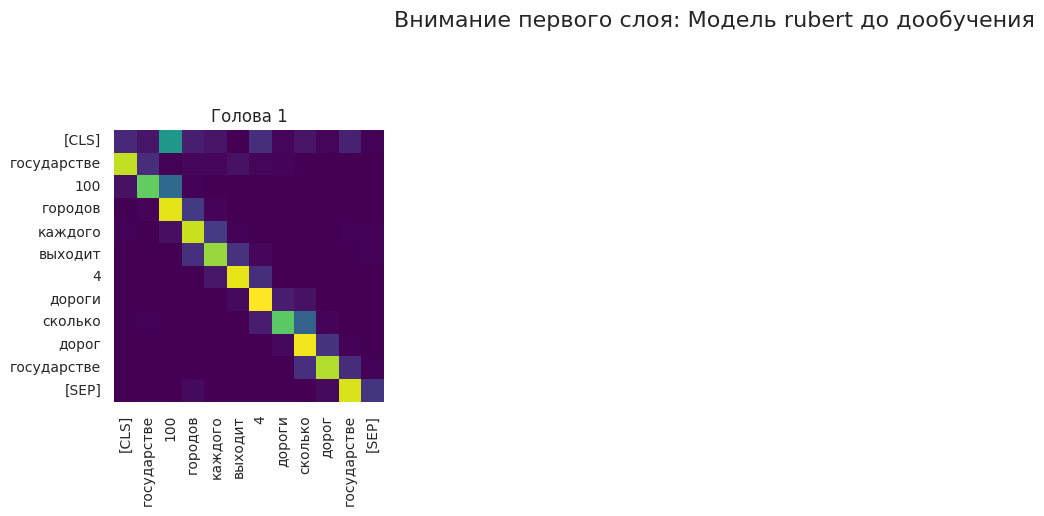

<Figure size 1000x1000 with 0 Axes>

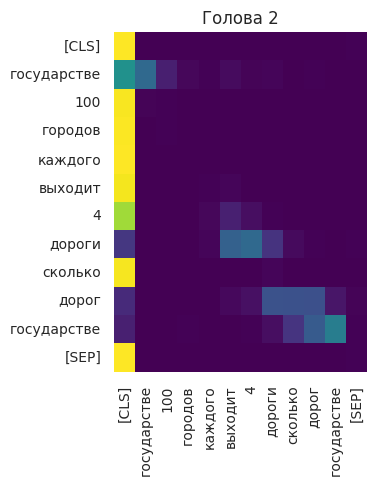

<Figure size 1000x1000 with 0 Axes>

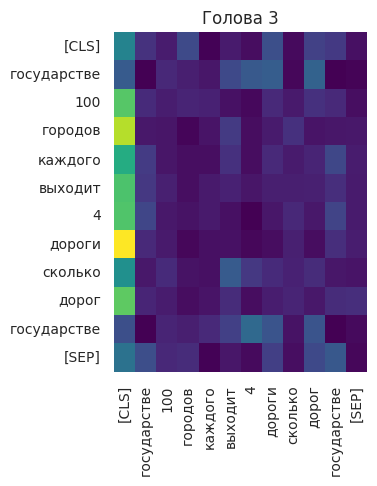

<Figure size 1000x1000 with 0 Axes>

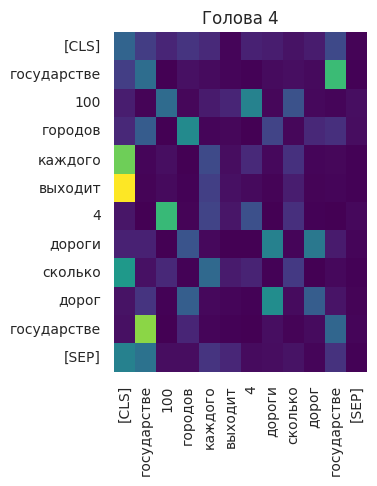

<Figure size 1000x1000 with 0 Axes>

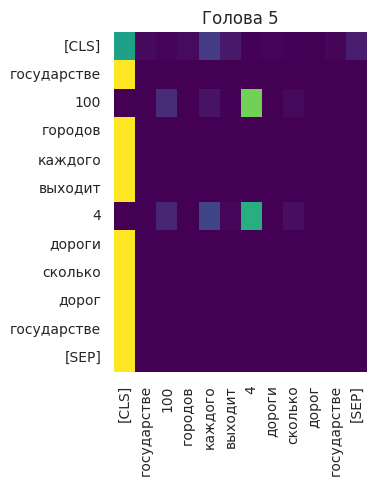

<Figure size 1000x1000 with 0 Axes>

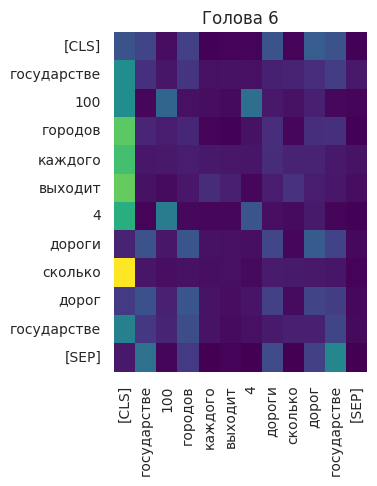

<Figure size 1000x1000 with 0 Axes>

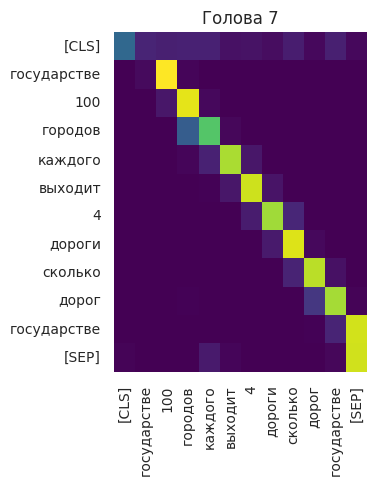

<Figure size 1000x1000 with 0 Axes>

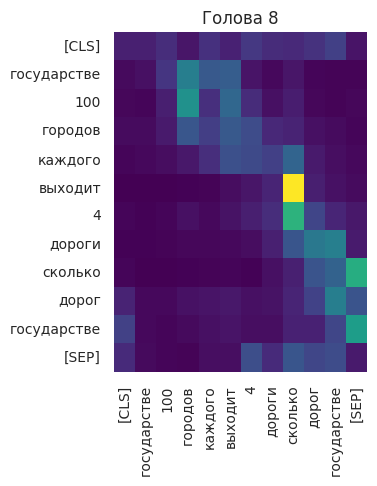

<Figure size 1000x1000 with 0 Axes>

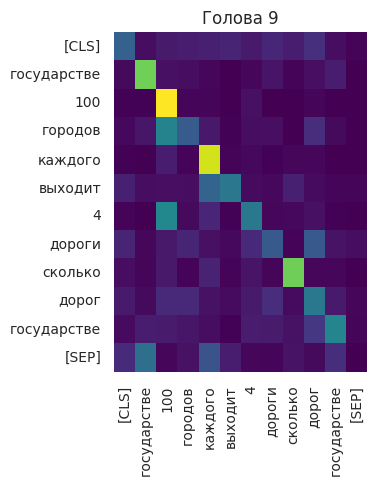

<Figure size 1000x1000 with 0 Axes>

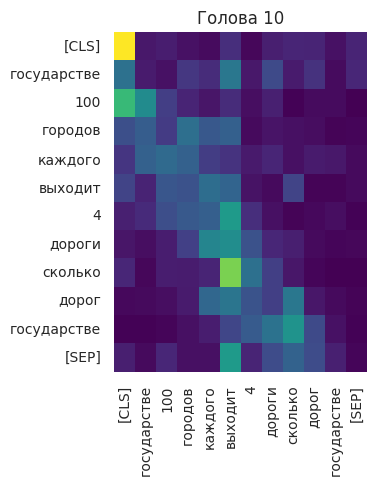

<Figure size 1000x1000 with 0 Axes>

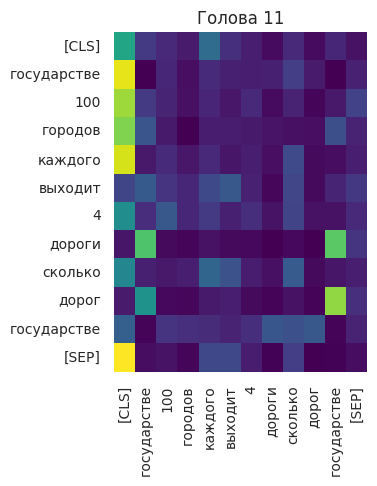

<Figure size 1000x1000 with 0 Axes>

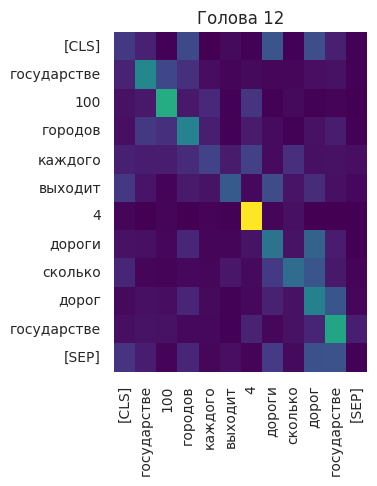

<Figure size 1000x1000 with 0 Axes>


Текст: классе 30 человек 9 имеют 3 друга классе 11 – 4 друга 10 – 5 друзей



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


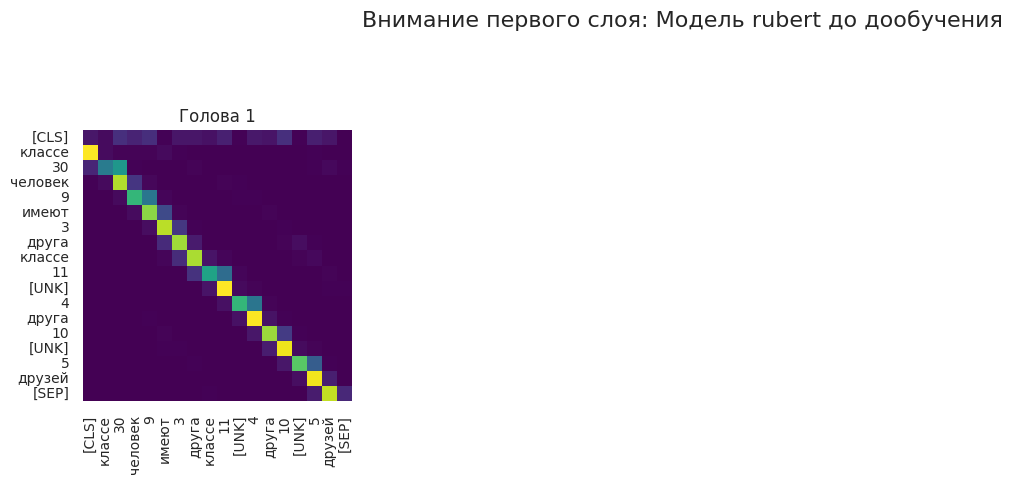

<Figure size 1000x1000 with 0 Axes>

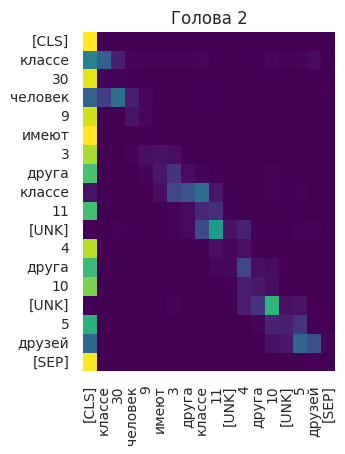

<Figure size 1000x1000 with 0 Axes>

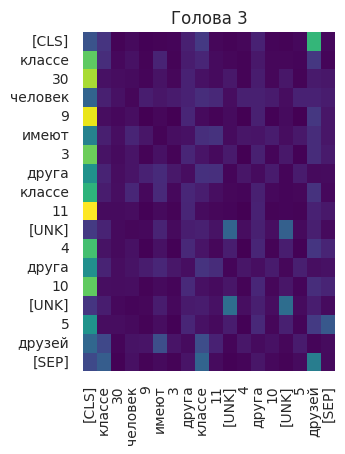

<Figure size 1000x1000 with 0 Axes>

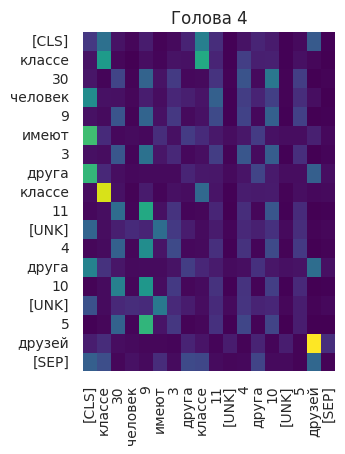

<Figure size 1000x1000 with 0 Axes>

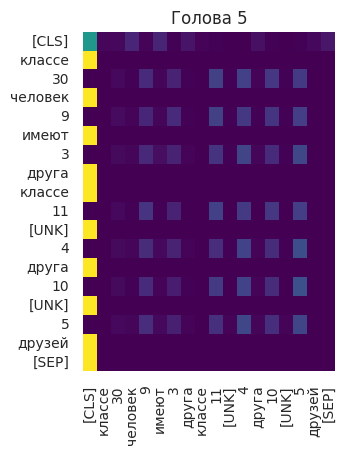

<Figure size 1000x1000 with 0 Axes>

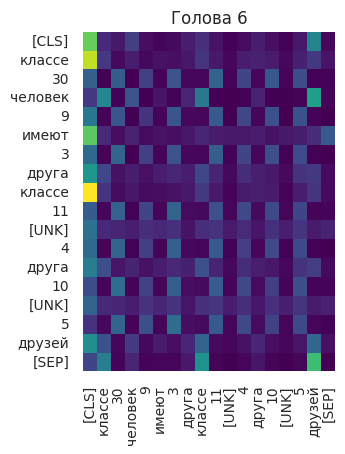

<Figure size 1000x1000 with 0 Axes>

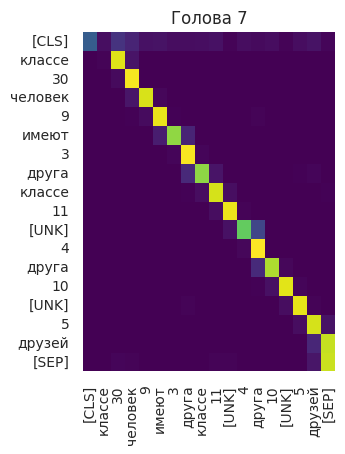

<Figure size 1000x1000 with 0 Axes>

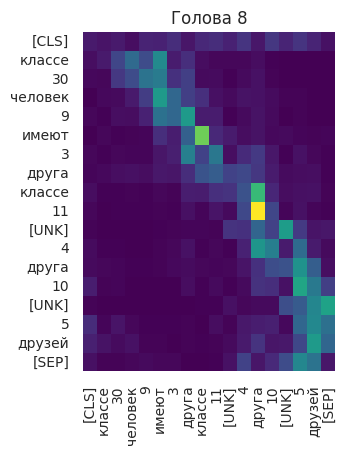

<Figure size 1000x1000 with 0 Axes>

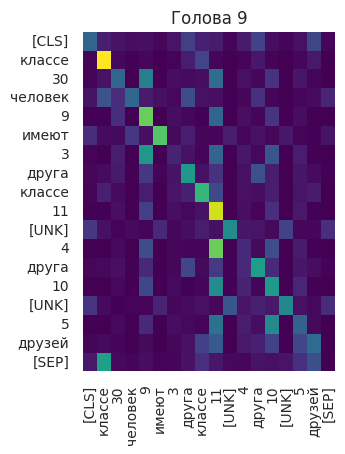

<Figure size 1000x1000 with 0 Axes>

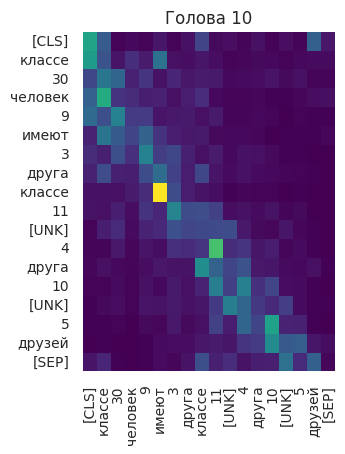

<Figure size 1000x1000 with 0 Axes>

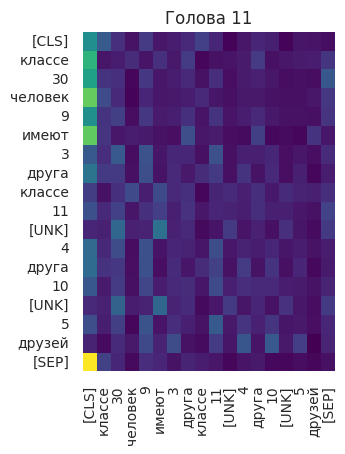

<Figure size 1000x1000 with 0 Axes>

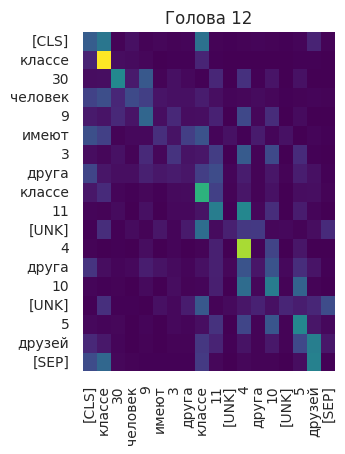

<Figure size 1000x1000 with 0 Axes>

In [65]:
#rubert
texts_ru=[data_ru['text'][2][:100],data_ru['text'][3][:100]]
for text in texts_ru:
    print(f"\nТекст: {text}\n")


    draw_first_layer_attention_maps(
        model=select_model(rubert_tiny_transformer_model), #выбор модели до дообучения
        tokenizer=select_tokenizer(rubert_tiny_transformer_model),
        text=text,
        model_name='Модель rubert до дообучения'
    )

Теперь проделаем то же самое для англоязычного датасета и соответствующей модели


Текст: quadratic threemember graph coefficients two points coordinates show distance whole number fraction 



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


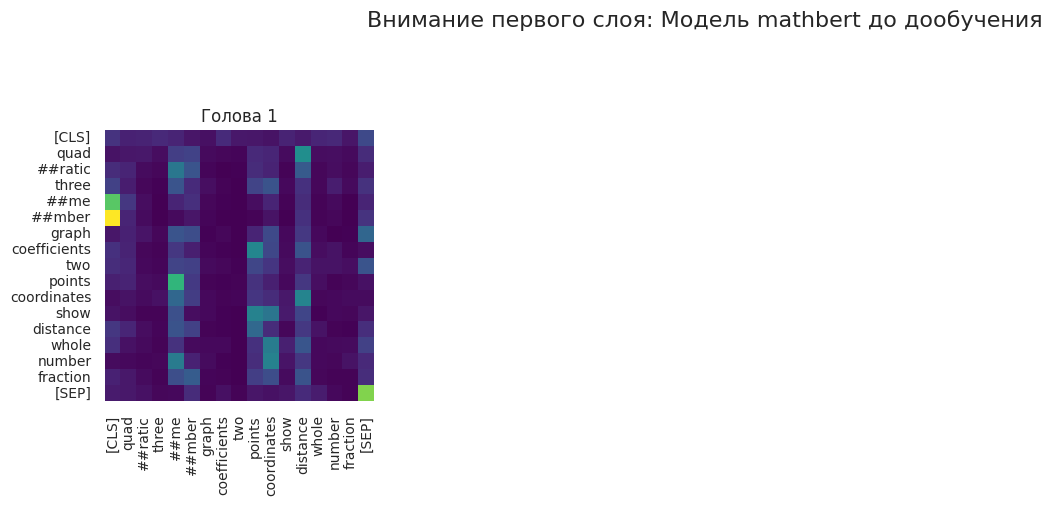

<Figure size 1000x1000 with 0 Axes>

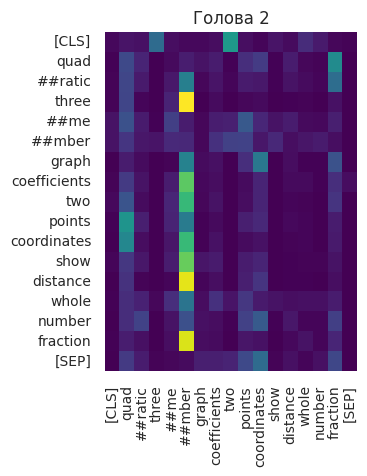

<Figure size 1000x1000 with 0 Axes>

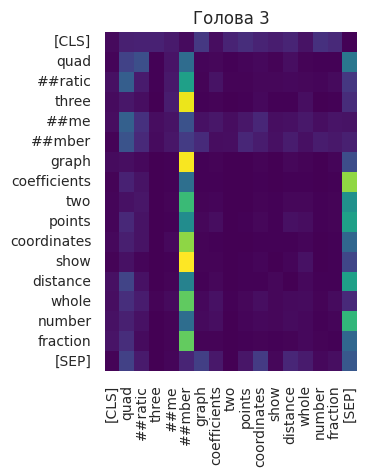

<Figure size 1000x1000 with 0 Axes>

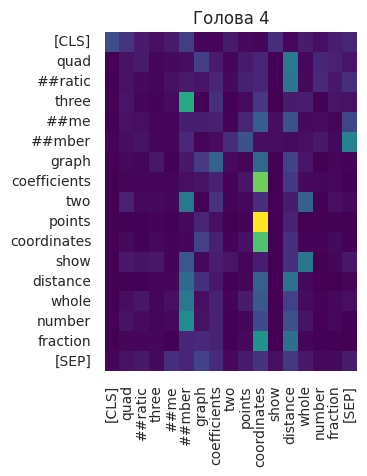

<Figure size 1000x1000 with 0 Axes>

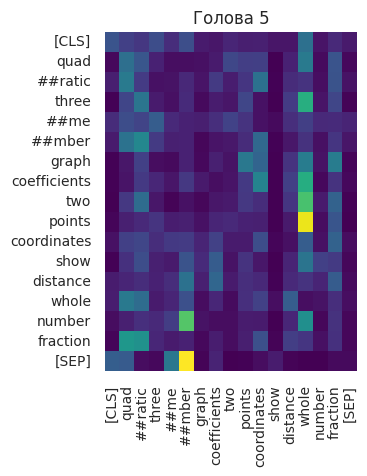

<Figure size 1000x1000 with 0 Axes>

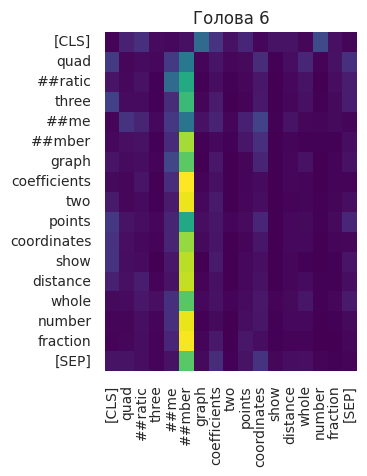

<Figure size 1000x1000 with 0 Axes>

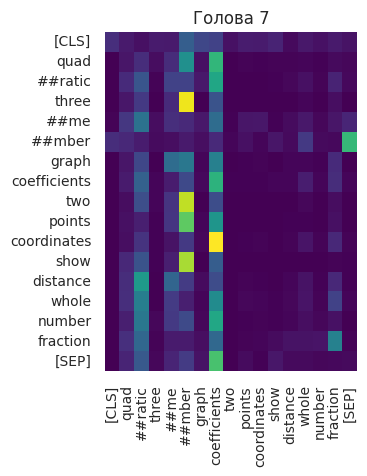

<Figure size 1000x1000 with 0 Axes>

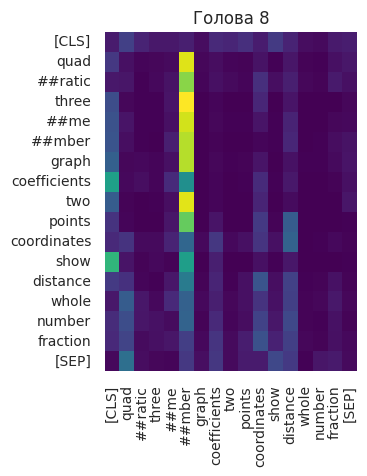

<Figure size 1000x1000 with 0 Axes>

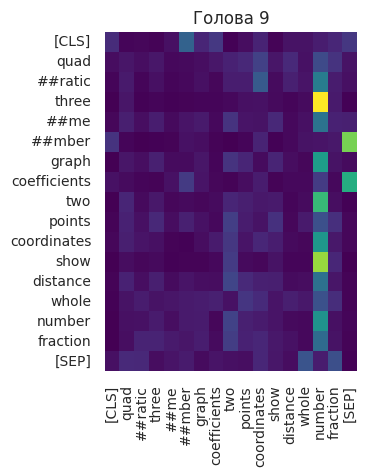

<Figure size 1000x1000 with 0 Axes>

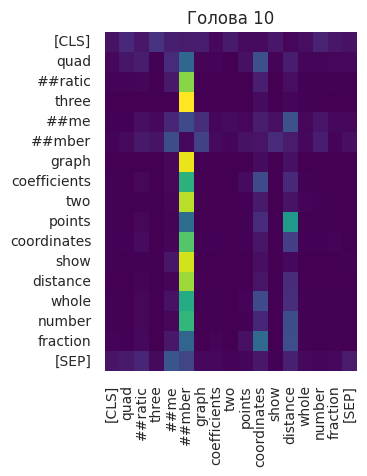

<Figure size 1000x1000 with 0 Axes>

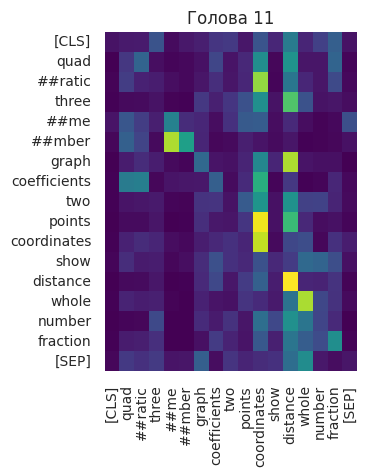

<Figure size 1000x1000 with 0 Axes>

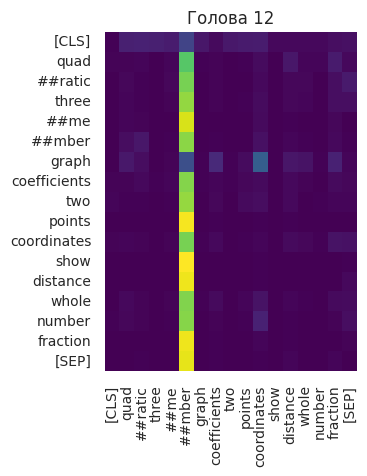

<Figure size 1000x1000 with 0 Axes>


Текст: draw surface rubiks cube closed path passes square exactly top square pass



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


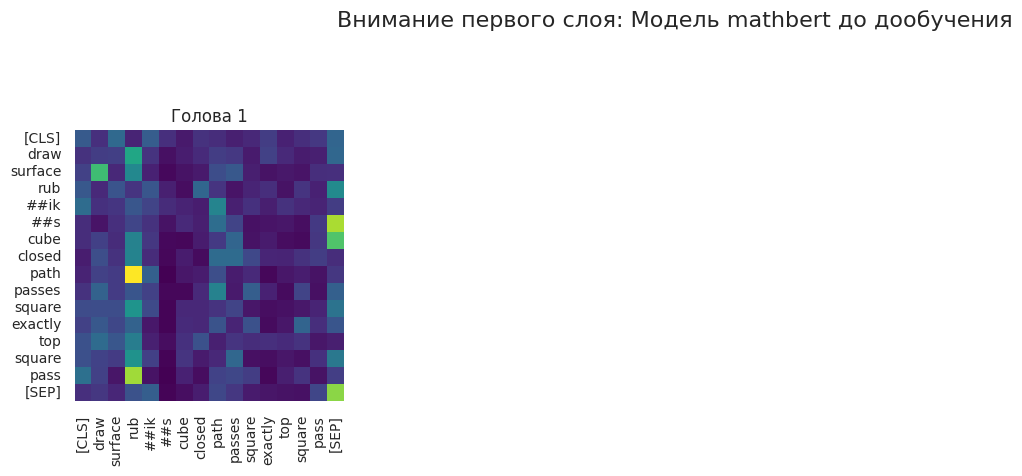

<Figure size 1000x1000 with 0 Axes>

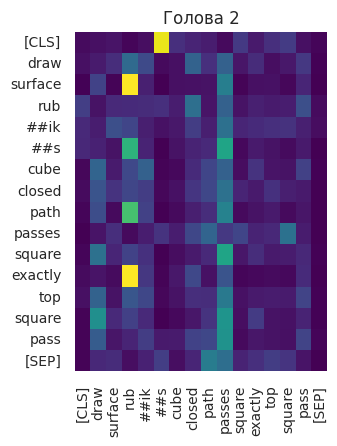

<Figure size 1000x1000 with 0 Axes>

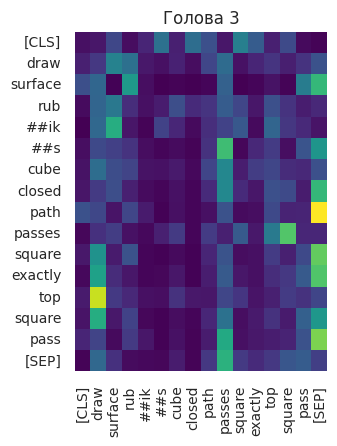

<Figure size 1000x1000 with 0 Axes>

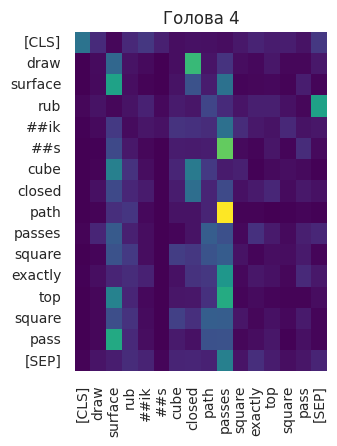

<Figure size 1000x1000 with 0 Axes>

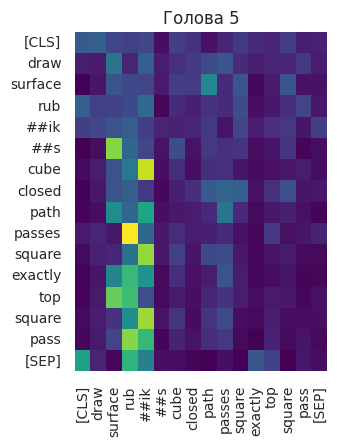

<Figure size 1000x1000 with 0 Axes>

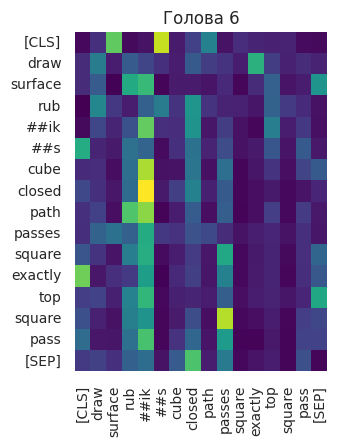

<Figure size 1000x1000 with 0 Axes>

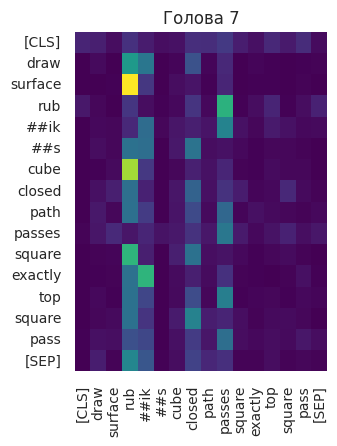

<Figure size 1000x1000 with 0 Axes>

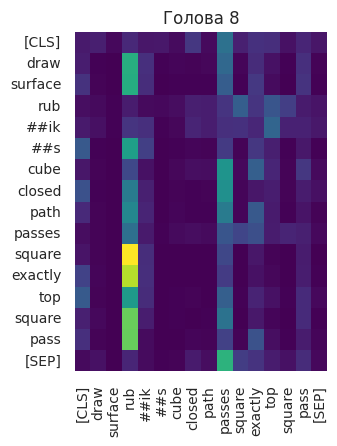

<Figure size 1000x1000 with 0 Axes>

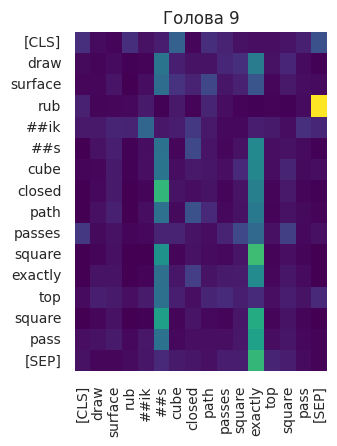

<Figure size 1000x1000 with 0 Axes>

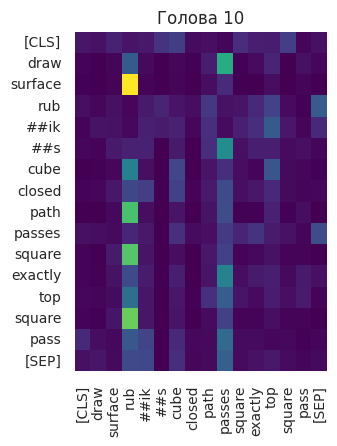

<Figure size 1000x1000 with 0 Axes>

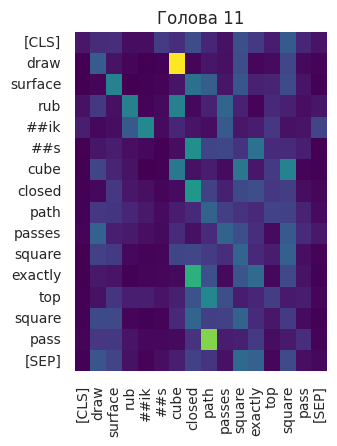

<Figure size 1000x1000 with 0 Axes>

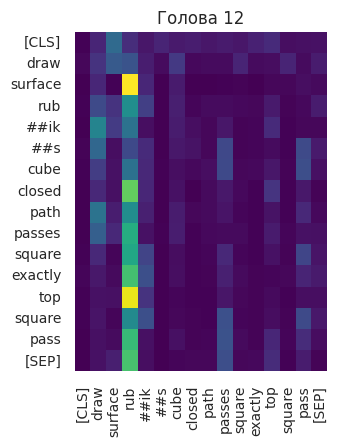

<Figure size 1000x1000 with 0 Axes>

In [66]:
#mathbert
texts_eng=[data_eng['text'][2][:100],data_eng['text'][3][:100]]
for text in texts_eng:
    print(f"\nТекст: {text}\n")


    draw_first_layer_attention_maps(
        model=select_model(MathBert_transformer_model), #выбор модели до дообучения
        tokenizer=select_tokenizer(MathBert_transformer_model),
        text=text,
        model_name='Модель mathbert до дообучения'
    )

Заметим, что для русскоязычной модели и датасета наибольшее внимание расположено рядом с главной диагональю, таким образом модель обращает внимание обычно  на соседние слова с текушим. В англоязычном датасете каждая голова выделяет внимание для конкретного слова/набора слов

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Проведем инференс на нескольких текстах с использованием уже дообученной модели

In [68]:
texts = [data_ru['text'][2],data_ru['text'][3]]
tokenizer1=select_tokenizer(rubert_tiny_transformer_model)
inputs = tokenizer1(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {k: v.to(device) for k, v in inputs.items()}
rubert_tiny_full_finetuned.eval()
with torch.no_grad():
    outputs = rubert_tiny_full_finetuned(**inputs)
    logits = outputs.logits
probabilities = F.softmax(logits, dim=1)
label_names = le.classes_
predicted_class_idxs = torch.argmax(probabilities, dim=1).tolist()
probabilities = probabilities.tolist()
for text, class_idx, probs in zip(texts, predicted_class_idxs, probabilities):
    predicted_class = label_names[class_idx]
    predicted_probability = probs[class_idx]
    print(f"Текст: {text}\nПредсказанный класс: {predicted_class}\nВероятность: {predicted_probability:.4f}\n")

Текст: государстве 100 городов каждого выходит 4 дороги сколько дорог государстве
Предсказанный класс: Графы
Вероятность: 0.4724

Текст: классе 30 человек 9 имеют 3 друга классе 11 – 4 друга 10 – 5 друзей
Предсказанный класс: Комбинаторика
Вероятность: 0.5514



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Предсказания соответствуют действительности

In [97]:
texts = [data_eng['text'][2],data_eng['text'][3]]
tokenizer2=select_tokenizer(MathBert_transformer_model)
inputs = tokenizer2(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {k: v.to(device) for k, v in inputs.items()}
MathBert_full_finetuned.eval()
with torch.no_grad():
    outputs = MathBert_full_finetuned(**inputs)
    logits = outputs.logits
probabilities = F.softmax(logits, dim=1)
label_names = le.classes_
predicted_class_idxs = torch.argmax(probabilities, dim=1).tolist()
probabilities = probabilities.tolist()
for text, class_idx, probs in zip(texts, predicted_class_idxs, probabilities):
    predicted_class = label_names[class_idx]
    predicted_probability = probs[class_idx]
    print(f"Текст: {text}\nПредсказанный класс: {predicted_class}\nВероятность: {predicted_probability:.4f}\n")

Текст: quadratic threemember graph coefficients two points coordinates show distance whole number fraction parallel abscisse axis
Предсказанный класс: Теория чисел
Вероятность: 0.8082

Текст: draw surface rubiks cube closed path passes square exactly top square pass
Предсказанный класс: Геометрия
Вероятность: 0.4467



Отрисуем карты внимания для уже дообученных моделей


Текст: государстве 100 городов каждого выходит 4 дороги сколько дорог государстве



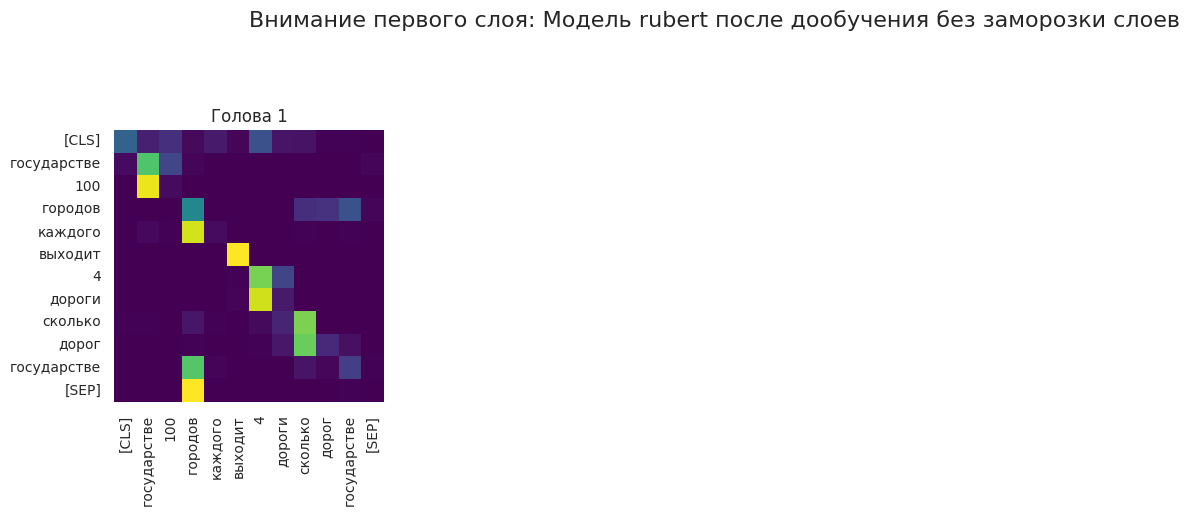

<Figure size 1000x1000 with 0 Axes>

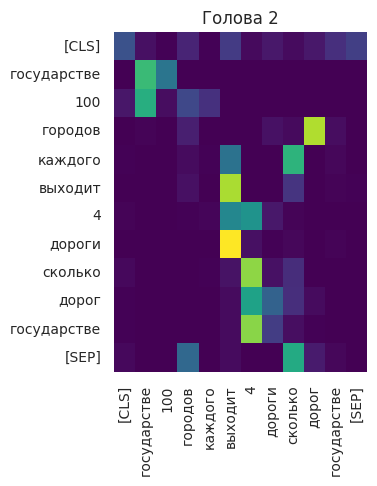

<Figure size 1000x1000 with 0 Axes>

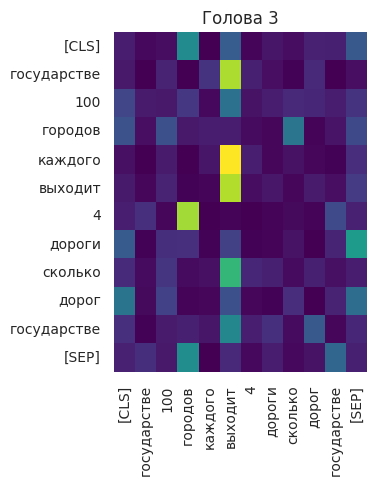

<Figure size 1000x1000 with 0 Axes>

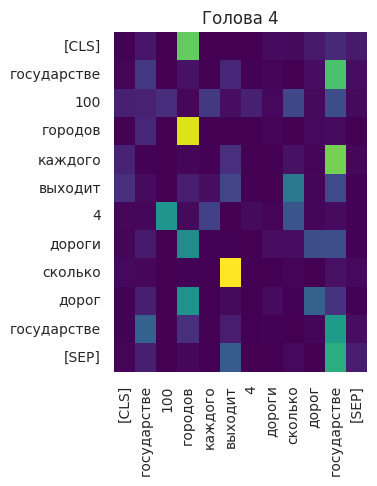

<Figure size 1000x1000 with 0 Axes>

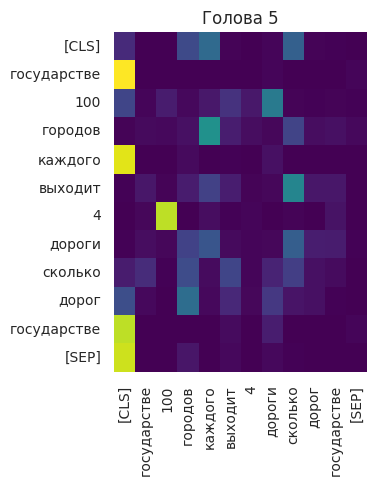

<Figure size 1000x1000 with 0 Axes>

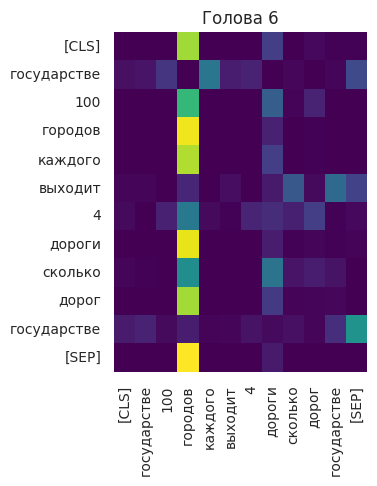

<Figure size 1000x1000 with 0 Axes>

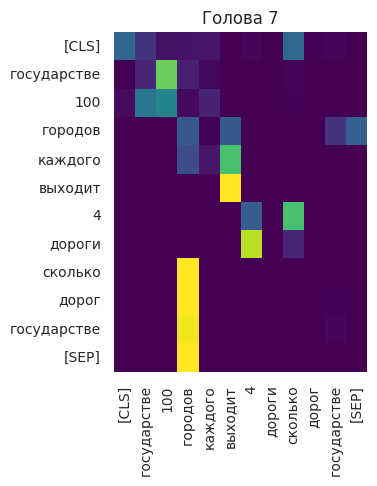

<Figure size 1000x1000 with 0 Axes>

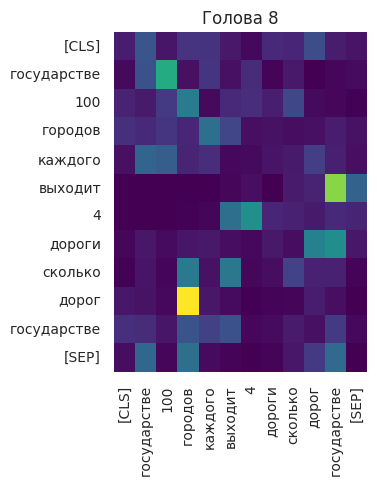

<Figure size 1000x1000 with 0 Axes>

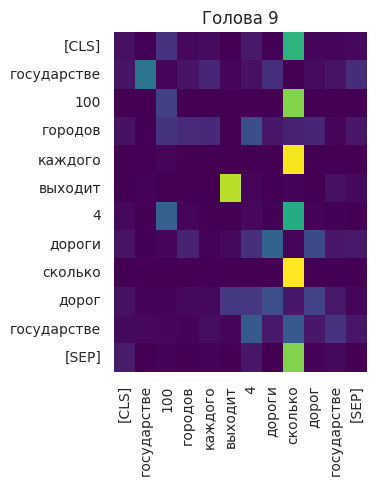

<Figure size 1000x1000 with 0 Axes>

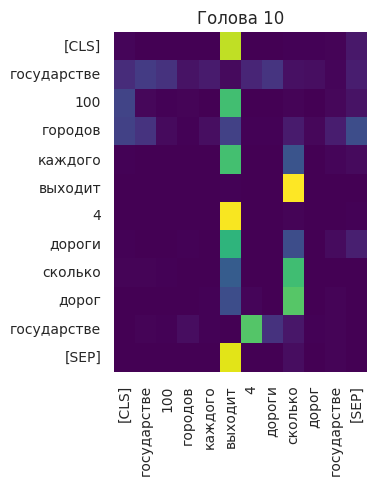

<Figure size 1000x1000 with 0 Axes>

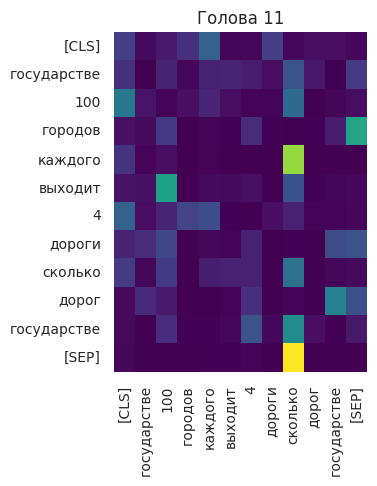

<Figure size 1000x1000 with 0 Axes>

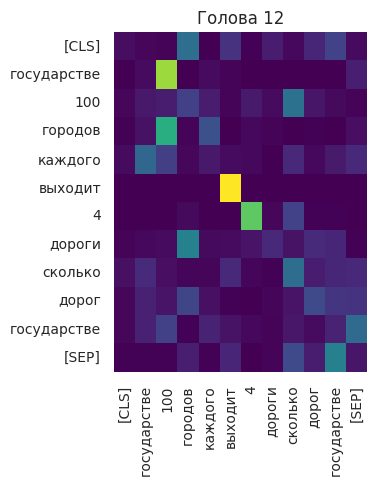

<Figure size 1000x1000 with 0 Axes>


Текст: классе 30 человек 9 имеют 3 друга классе 11 – 4 друга 10 – 5 друзей



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


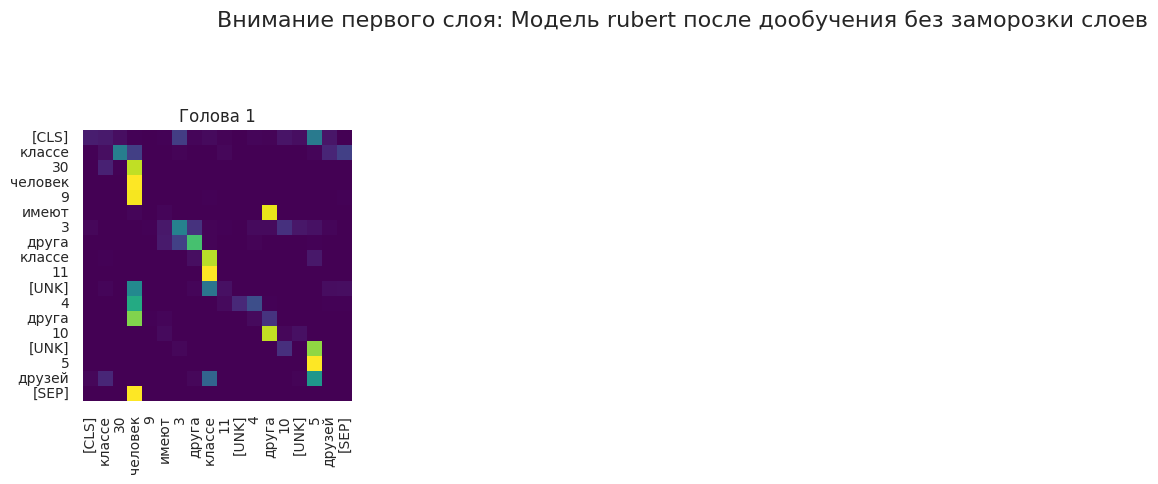

<Figure size 1000x1000 with 0 Axes>

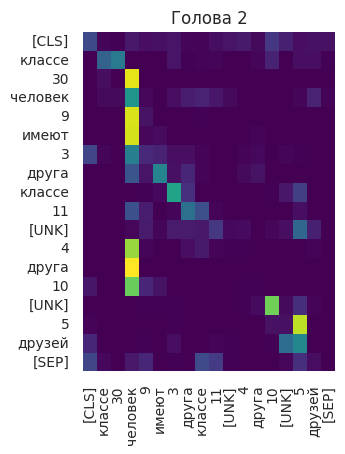

<Figure size 1000x1000 with 0 Axes>

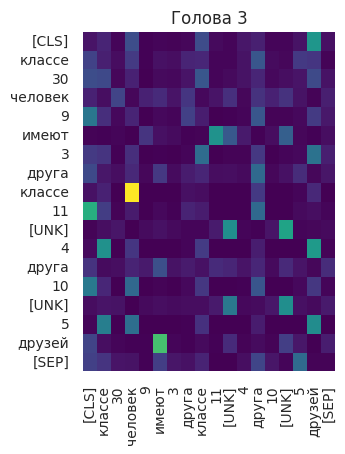

<Figure size 1000x1000 with 0 Axes>

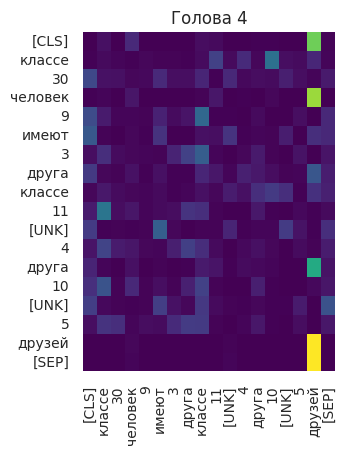

<Figure size 1000x1000 with 0 Axes>

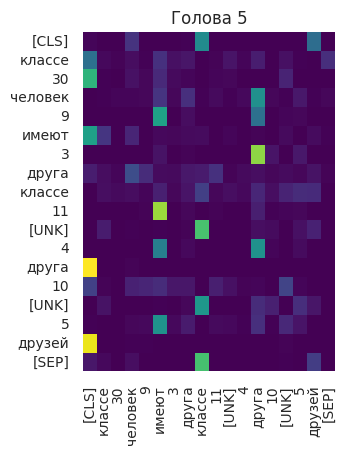

<Figure size 1000x1000 with 0 Axes>

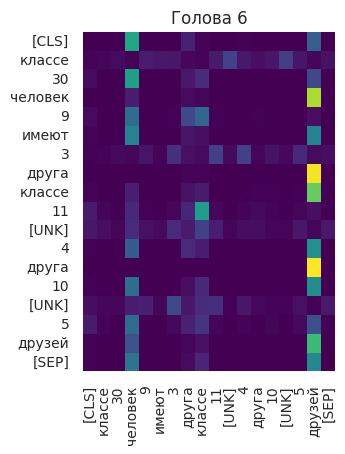

<Figure size 1000x1000 with 0 Axes>

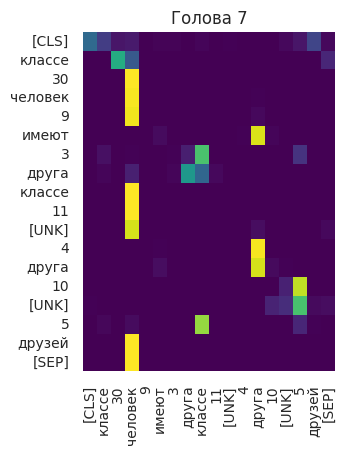

<Figure size 1000x1000 with 0 Axes>

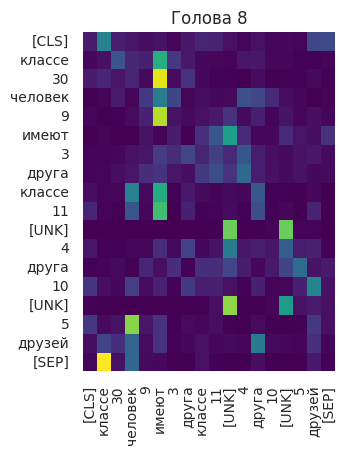

<Figure size 1000x1000 with 0 Axes>

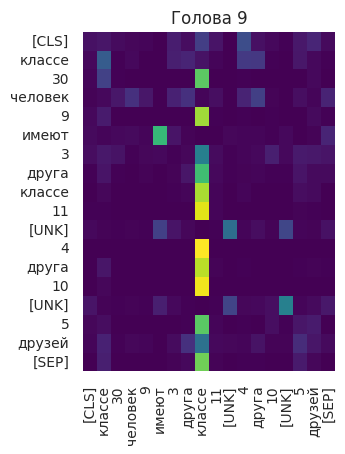

<Figure size 1000x1000 with 0 Axes>

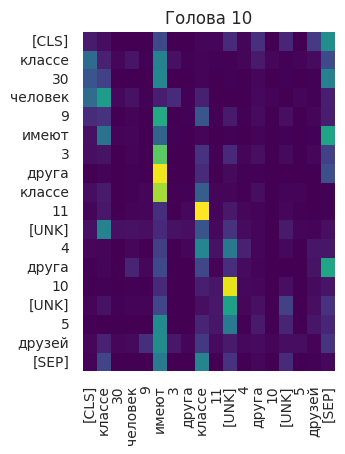

<Figure size 1000x1000 with 0 Axes>

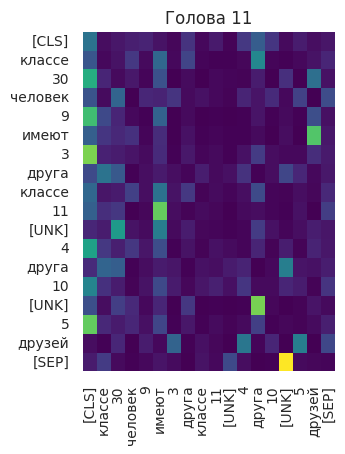

<Figure size 1000x1000 with 0 Axes>

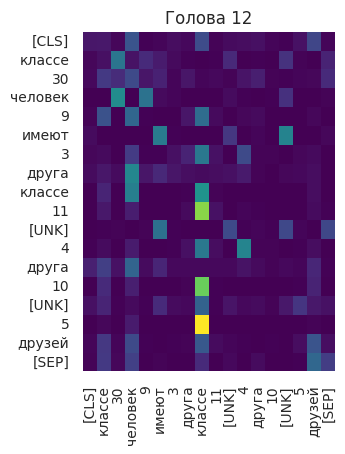

<Figure size 1000x1000 with 0 Axes>

In [98]:
for text in texts_ru:
    print(f"\nТекст: {text}\n")


    draw_first_layer_attention_maps(
        model=rubert_tiny_full_finetuned,
        tokenizer=select_tokenizer(rubert_tiny_transformer_model),
        text=text,
        model_name='Модель rubert после дообучения без заморозки слоев'
    )


Текст: quadratic threemember graph coefficients two points coordinates show distance whole number fraction 



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


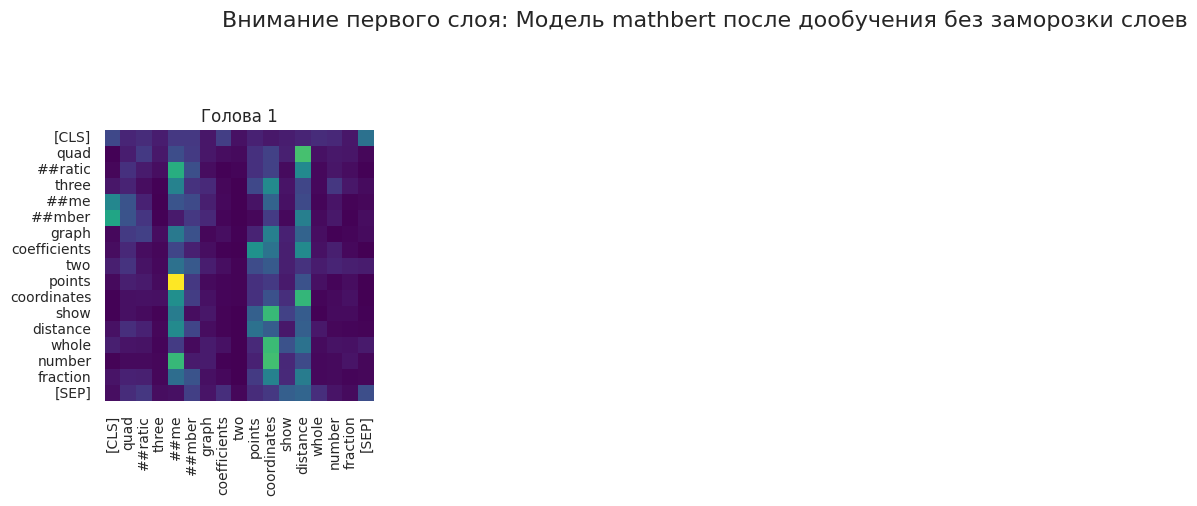

<Figure size 1000x1000 with 0 Axes>

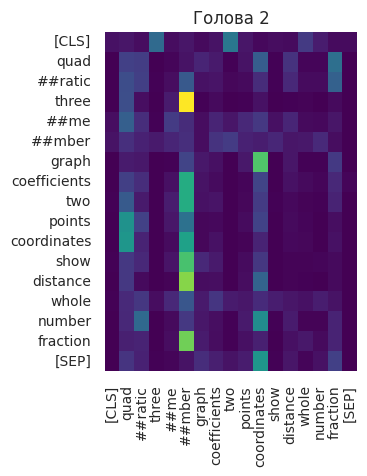

<Figure size 1000x1000 with 0 Axes>

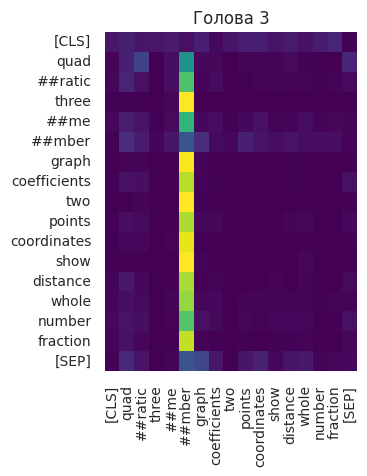

<Figure size 1000x1000 with 0 Axes>

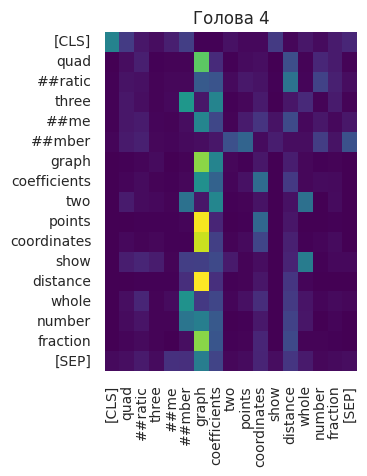

<Figure size 1000x1000 with 0 Axes>

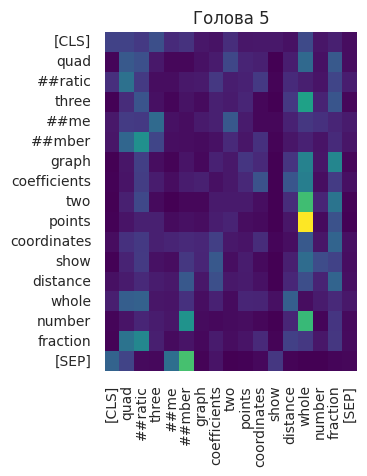

<Figure size 1000x1000 with 0 Axes>

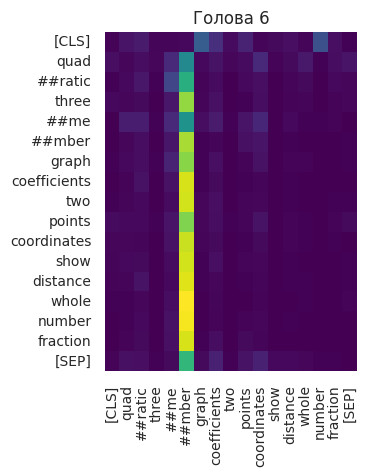

<Figure size 1000x1000 with 0 Axes>

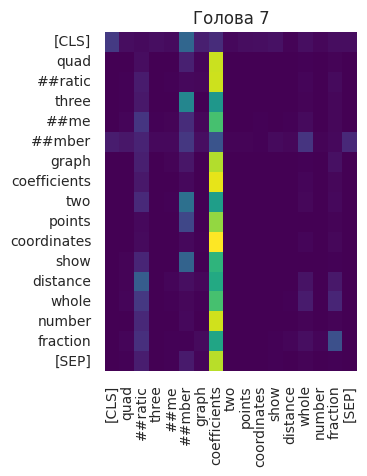

<Figure size 1000x1000 with 0 Axes>

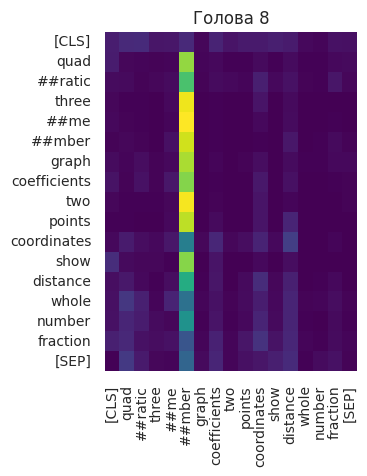

<Figure size 1000x1000 with 0 Axes>

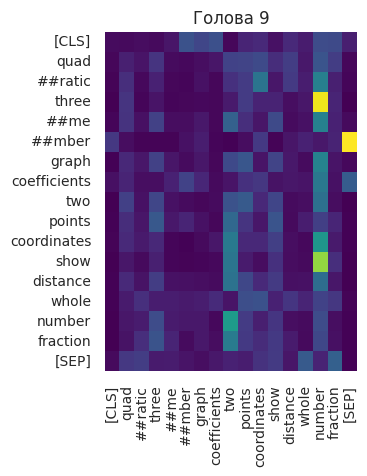

<Figure size 1000x1000 with 0 Axes>

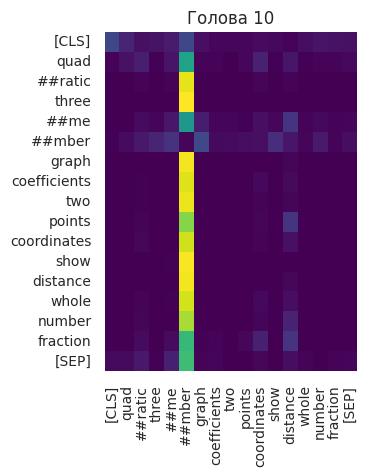

<Figure size 1000x1000 with 0 Axes>

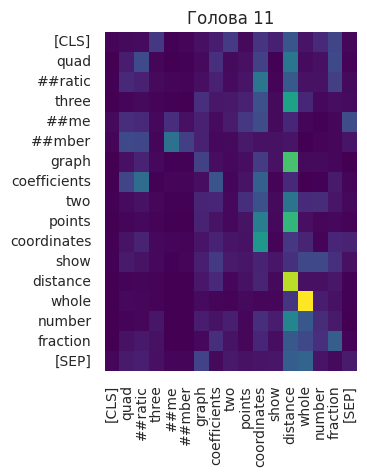

<Figure size 1000x1000 with 0 Axes>

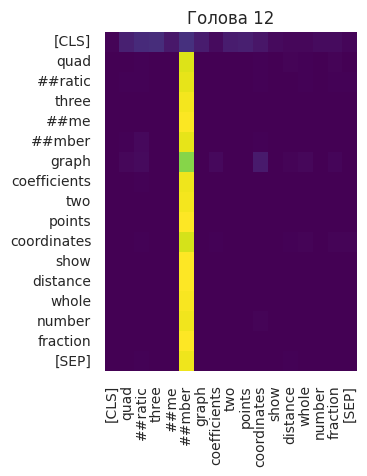

<Figure size 1000x1000 with 0 Axes>


Текст: draw surface rubiks cube closed path passes square exactly top square pass



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


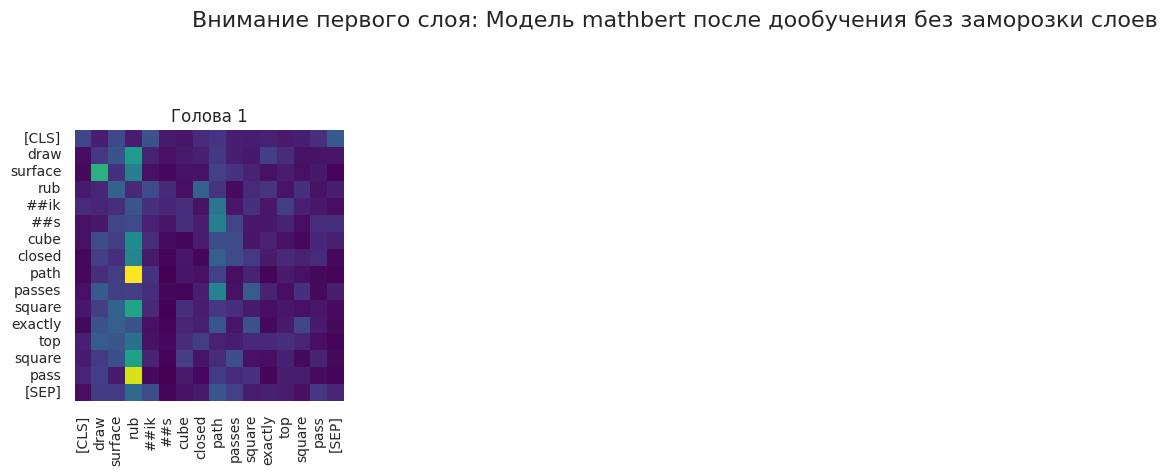

<Figure size 1000x1000 with 0 Axes>

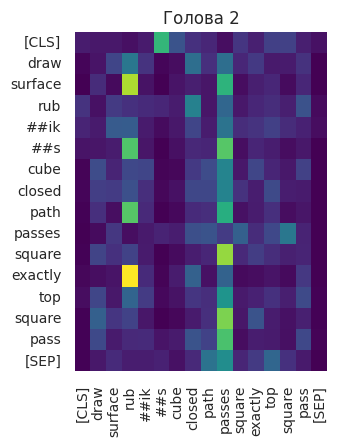

<Figure size 1000x1000 with 0 Axes>

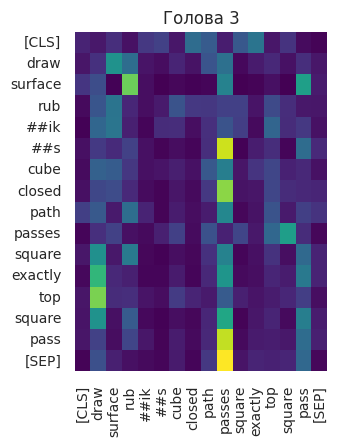

<Figure size 1000x1000 with 0 Axes>

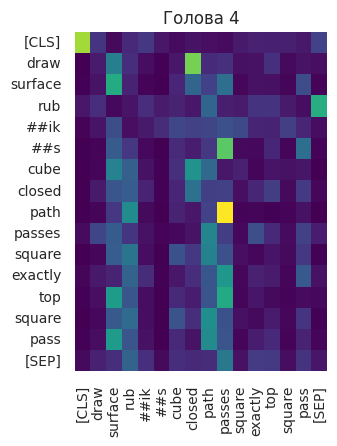

<Figure size 1000x1000 with 0 Axes>

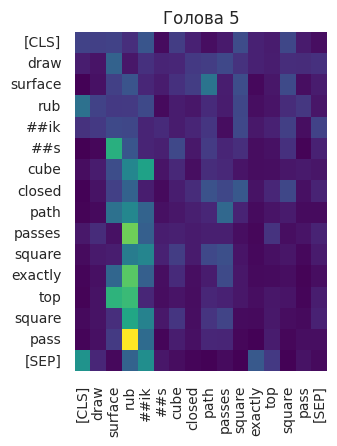

<Figure size 1000x1000 with 0 Axes>

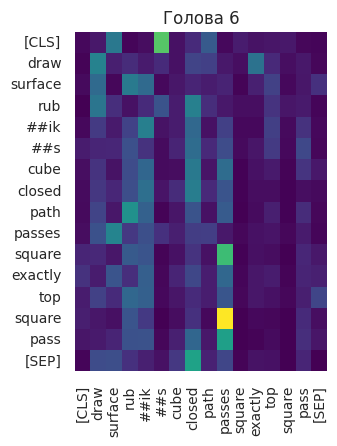

<Figure size 1000x1000 with 0 Axes>

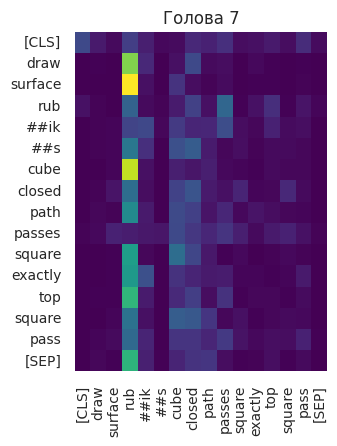

<Figure size 1000x1000 with 0 Axes>

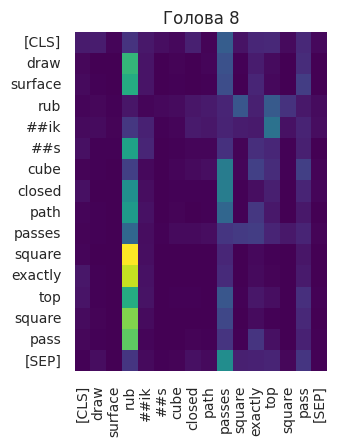

<Figure size 1000x1000 with 0 Axes>

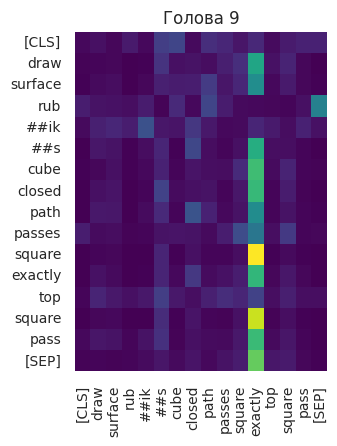

<Figure size 1000x1000 with 0 Axes>

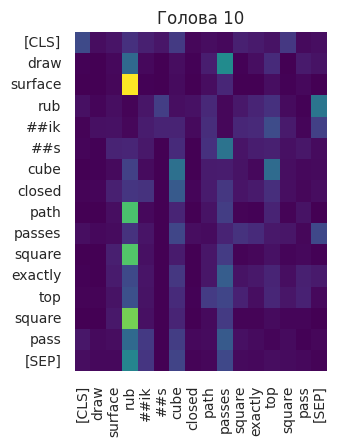

<Figure size 1000x1000 with 0 Axes>

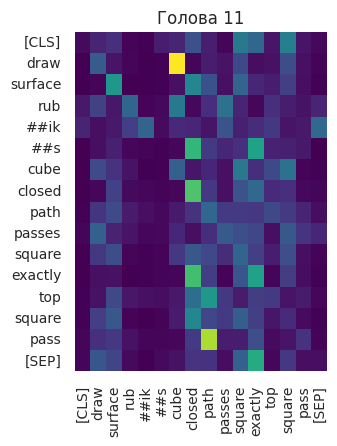

<Figure size 1000x1000 with 0 Axes>

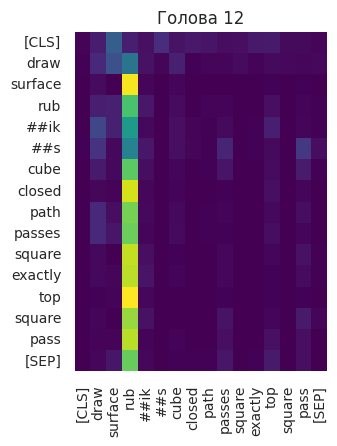

<Figure size 1000x1000 with 0 Axes>

In [99]:
for text in texts_eng:
    print(f"\nТекст: {text}\n")



    draw_first_layer_attention_maps(
        model=MathBert_full_finetuned,
        tokenizer=select_tokenizer(MathBert_transformer_model),
        text=text,
        model_name='Модель mathbert после дообучения без заморозки слоев'
    )

In [81]:
# так как первые слои заморожены в случае выбора freeze_backbone, а мы рассматриваем первый слой attention, то скорее всего замороженные модели нет смысла рассматривать

Карты внимания и связи изменились для дообученных моделей, поскольку, в отличие от моделей с замороженным backbone или моделей до дообучения, теперь обновление весов происходит на всех слоях на каждой эпохе

После дообучения карты внимания каждой головы больше улавливают связи для отдельных слов и словосочетаний